In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech.keys import (items,
                             race_to_col,
                             annotator_race_to_col,
                             annotator_gender,
                             annotator_educ,
                             annotator_income,
                             annotator_religion_to_col,
                             annotator_sexual_orientation_to_col,
                             annotator_ideology)
from hatespeech import utils
from IPython.display import Markdown
from scipy.stats import f_oneway, kruskal

%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
mplego.style.use_latex_style()

In [14]:
exp = "08"
base_path = os.path.join(os.environ['HOME'], 'projects/hatespeech-2021-fairml')
data_path = os.path.join(os.environ['HOME'], 'data/hatespeech/clean_qualtrics_irt_rollout.feather')
rater_quality_path = "~/data/hatespeech/rater_quality_check.csv"
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')

In [15]:
data = pd.read_feather(data_path).rename(columns={'violence_phys': 'violence'})
# Remove all rows in which some item is missing
data = utils.filter_missing_items(data)
# Remove all rows in which the rater is not up to sufficient quality
rater_quality = pd.read_csv(rater_quality_path)
data = utils.filter_annotator_quality(data, rater_quality)
# Recode item responses
data = utils.recode_responses(
    data,
    insult={1: 0, 2: 1, 3: 2, 4: 3},
    humiliate={1: 0, 2: 0, 3: 1, 4: 2},
    status={1: 0, 2: 0, 3: 1, 4: 1},
    dehumanize={1: 0, 2: 0, 3: 1, 4: 1},
    violence={1: 0, 2: 0, 3: 1, 4: 1},
    genocide={1: 0, 2: 0, 3: 1, 4: 1},
    attack_defend={1: 0, 2: 1, 3: 2, 4: 3},
    hatespeech={1: 0, 2: 1})
data = data[(data[race_to_col['black']] == 1)
            | (data[race_to_col['white']] == 1)]


In [16]:
avg_scores = data.groupby('comment_id')[items].mean()

In [17]:
out_path = os.path.join(results_path, f"exp08_out.txt")

In [18]:
with open(out_path) as f:
    lines = f.readlines()

In [22]:
bias_lines = lines[26223:26287]

In [119]:
races = {
    'asian': 3,
    'black': 1,
    'latinx': 2,
    'middleeastern': 4,
    'nativeamerican': 5,
    'pacificislander': 6,
    'white': 0,
    'other': 7
}

In [131]:
np.array(list(races.keys()))[np.argsort(list(races.values()))]

array(['white', 'black', 'latinx', 'asian', 'middleeastern',
       'nativeamerican', 'pacificislander', 'other'], dtype='<U15')

In [129]:
np.array(races.keys())

array(dict_keys(['asian', 'black', 'latinx', 'middleeastern', 'nativeamerican', 'pacificislander', 'white', 'other']),
      dtype=object)

In [120]:
n_samples = len(bias_lines)
observed = np.zeros(n_samples)
expected = np.zeros(n_samples)
bias_size = np.zeros(n_samples)
t_stats = np.zeros(n_samples)
p_vals = np.zeros(n_samples)
target = np.zeros(n_samples, dtype=str)
annotator = np.zeros(n_samples, dtype=str)
biases = np.zeros((8, 8))
p_values = np.zeros((8, 8))

for idx, line in enumerate(bias_lines):
    processed = line.replace('|', ' ').replace('>', ' ').replace('<', ' ').split()
    observed[idx] = float(processed[0])
    expected[idx] = float(processed[1])
    bias_size[idx] = float(processed[4])
    t_stats[idx] = float(processed[6])
    p_vals[idx] = float(processed[8])
    target[idx] = processed[13]
    annotator[idx] = processed[16]

    ii = races[line[88:105].replace(' ', '')]
    jj = races[line[112:132].replace(' ', '')]
    biases[ii, jj] = -float(processed[4])
    
    p_values[ii, jj] = float(processed[8])

In [121]:
races

{'asian': 3,
 'black': 1,
 'latinx': 2,
 'middleeastern': 4,
 'nativeamerican': 5,
 'pacificislander': 6,
 'white': 0,
 'other': 7}

<BarContainer object of 8 artists>

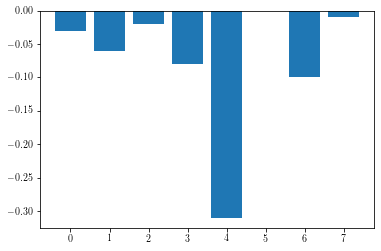

In [122]:
plt.bar(x=np.arange(8), height=np.diag(biases))

In [106]:
dir(mplego.colorbar)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'append_colorbar_to_axis',
 'append_marginal_axis',
 'np',
 'plt',
 'scale_values_to_cmap']

In [116]:
p_values < 0.1

array([[ True, False,  True,  True, False, False, False, False],
       [False,  True, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False,  True,  True, False, False,  True],
       [False,  True, False,  True, False, False, False,  True],
       [False, False, False, False, False, False,  True,  True],
       [False,  True,  True, False, False, False,  True, False],
       [ True, False, False, False, False, False, False, False]])

(<matplotlib.colorbar.Colorbar at 0x7ff4bd148810>, <Axes:>)

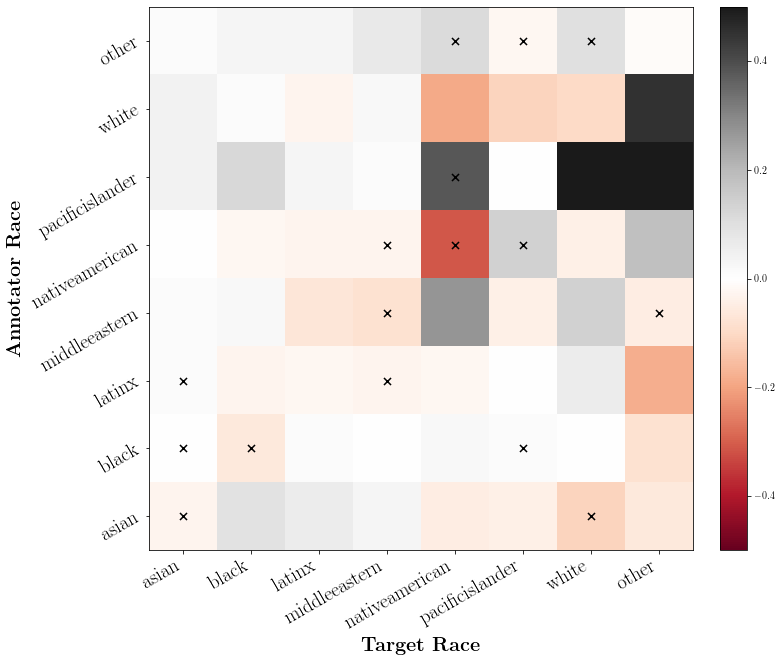

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
img = ax.imshow(biases, cmap='RdGy', vmax=0.5, vmin=-0.5, origin='lower')
ax.set_xticks(np.arange(8))
ax.set_yticks(np.arange(8))
ax.set_xticklabels(list(races.keys()), rotation=30, ha='right')
ax.set_yticklabels(list(races.keys()), rotation=30, ha='right')
ax.tick_params(labelsize=20)

for ii in range(p_values.shape[0]):
    for jj in range(p_values.shape[1]):
        if p_values[ii, jj] < 0.1:
            ax.scatter(ii, jj, marker='x', color='black', s=50)

ax.set_xlabel(r'\textbf{Target Race}', fontsize=20)
ax.set_ylabel(r'\textbf{Annotator Race}', fontsize=20)
mplego.colorbar.append_colorbar_to_axis(ax, img)

In [34]:
df = pd.DataFrame({
    'observed': observed,
    'expected': expected,
    'bias': bias_size,
    't_statistics': t_stats,
    'p_values': p_vals,
    'target_race': target,
    'annotator_race': annotator})

In [35]:
df['bias_corrected'] = -df['bias']
df['bias_abs'] = df['bias'].abs()

In [36]:
df

,observed,expected,bias,t_statistics,p_values,target_race,annotator_race,bias_corrected,bias_abs
0,4967.0,4974.88,-0.01,-0.28,0.7794,b,n,0.01,0.01
1,2014.0,2013.03,0.00,0.06,0.9535,l,n,-0.00,0.00
2,1830.0,1820.75,0.04,0.59,0.5559,a,n,-0.04,0.04
3,277.0,276.73,0.00,0.03,0.9735,n,n,-0.00,0.00
4,654.0,638.67,0.11,1.32,0.1878,p,n,-0.11,0.11
...,...,...,...,...,...,...,...,...,...
59,77.0,84.22,-0.38,-1.67,0.0988,n,m,0.38,0.38
60,282.0,272.81,0.19,1.33,0.1862,p,m,-0.19,0.19
61,395.0,390.20,0.05,0.50,0.6169,w,m,-0.05,0.05
62,290.0,296.59,-0.11,-0.84,0.3999,o,m,0.11,0.11
